In [1]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns  # more plots
sns.set()

%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv("orders.csv")
df

,created_at_utc,tariff_class,tariff_internal_name,status,taxi_status,vehicle_model,vehicle_color,vehicle_car_region,payment_cost,payment_currency_code,driver_call_model
0,1622145491,Эконом,econom,cancelled,waiting,Kia Rio,белый,34,52.00,RUB,no_call
1,1622145422,Эконом,econom,cancelled,driving,LADA (ВАЗ) Granta,серый,34,0.00,RUB,no_call
2,1622145212,Эконом,econom,finished,complete,Renault Logan,белый,34,104.70,RUB,on_demand
3,1622054615,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,белый,34,120.00,RUB,on_demand
4,1622045036,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,белый,34,115.50,RUB,on_demand
...,...,...,...,...,...,...,...,...,...,...,...
1200,1617028952,Эконом,econom,finished,complete,LADA (ВАЗ) Largus,белый,34,472.40,RUB,no_call
1201,1617028458,Эконом,econom,cancelled,driving,LADA (ВАЗ) Granta,белый,34,0.00,RUB,no_call
1202,1617025078,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,серый,34,146.85,RUB,no_call
1203,1616869125,Эконом,econom,cancelled,driving,LADA (ВАЗ) Largus,серый,34,0.00,RUB,no_call


In [3]:
df = pd.read_csv("orders.csv")
df = df.loc[df['payment_cost']!=0]
df = df.dropna()

In [4]:
#Turned out to be easier to predict if deveided to classes like Econom or Comfort.
df = df.loc[df.tariff_internal_name == 'econom']

In [5]:
#Converting to date-time
df = df[['created_at_utc','payment_cost']]
df['created_at_utc'] = pd.to_datetime(df.created_at_utc, unit='s')
df['created_at_utc'] = df['created_at_utc'].dt.date
df = df.groupby('created_at_utc').payment_cost.mean()
df = df.reset_index()
df.sort_values(by=['created_at_utc'], inplace=True)
df.set_index('created_at_utc', inplace=True)

df

,payment_cost
created_at_utc,
2017-09-30,78.775000
2017-10-18,438.150000
2017-10-19,425.500000
2017-10-27,98.325000
2017-11-02,96.025000
...,...
2021-05-23,555.225000
2021-05-24,73.450000
2021-05-25,435.683333


## Visual analysis

In [6]:
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
from IPython.display import display, IFrame

# Initialize plotly
init_notebook_mode(connected=True)

In [7]:
# Importing everything for Time Series

import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations




<Figure size 1000x600 with 0 Axes>

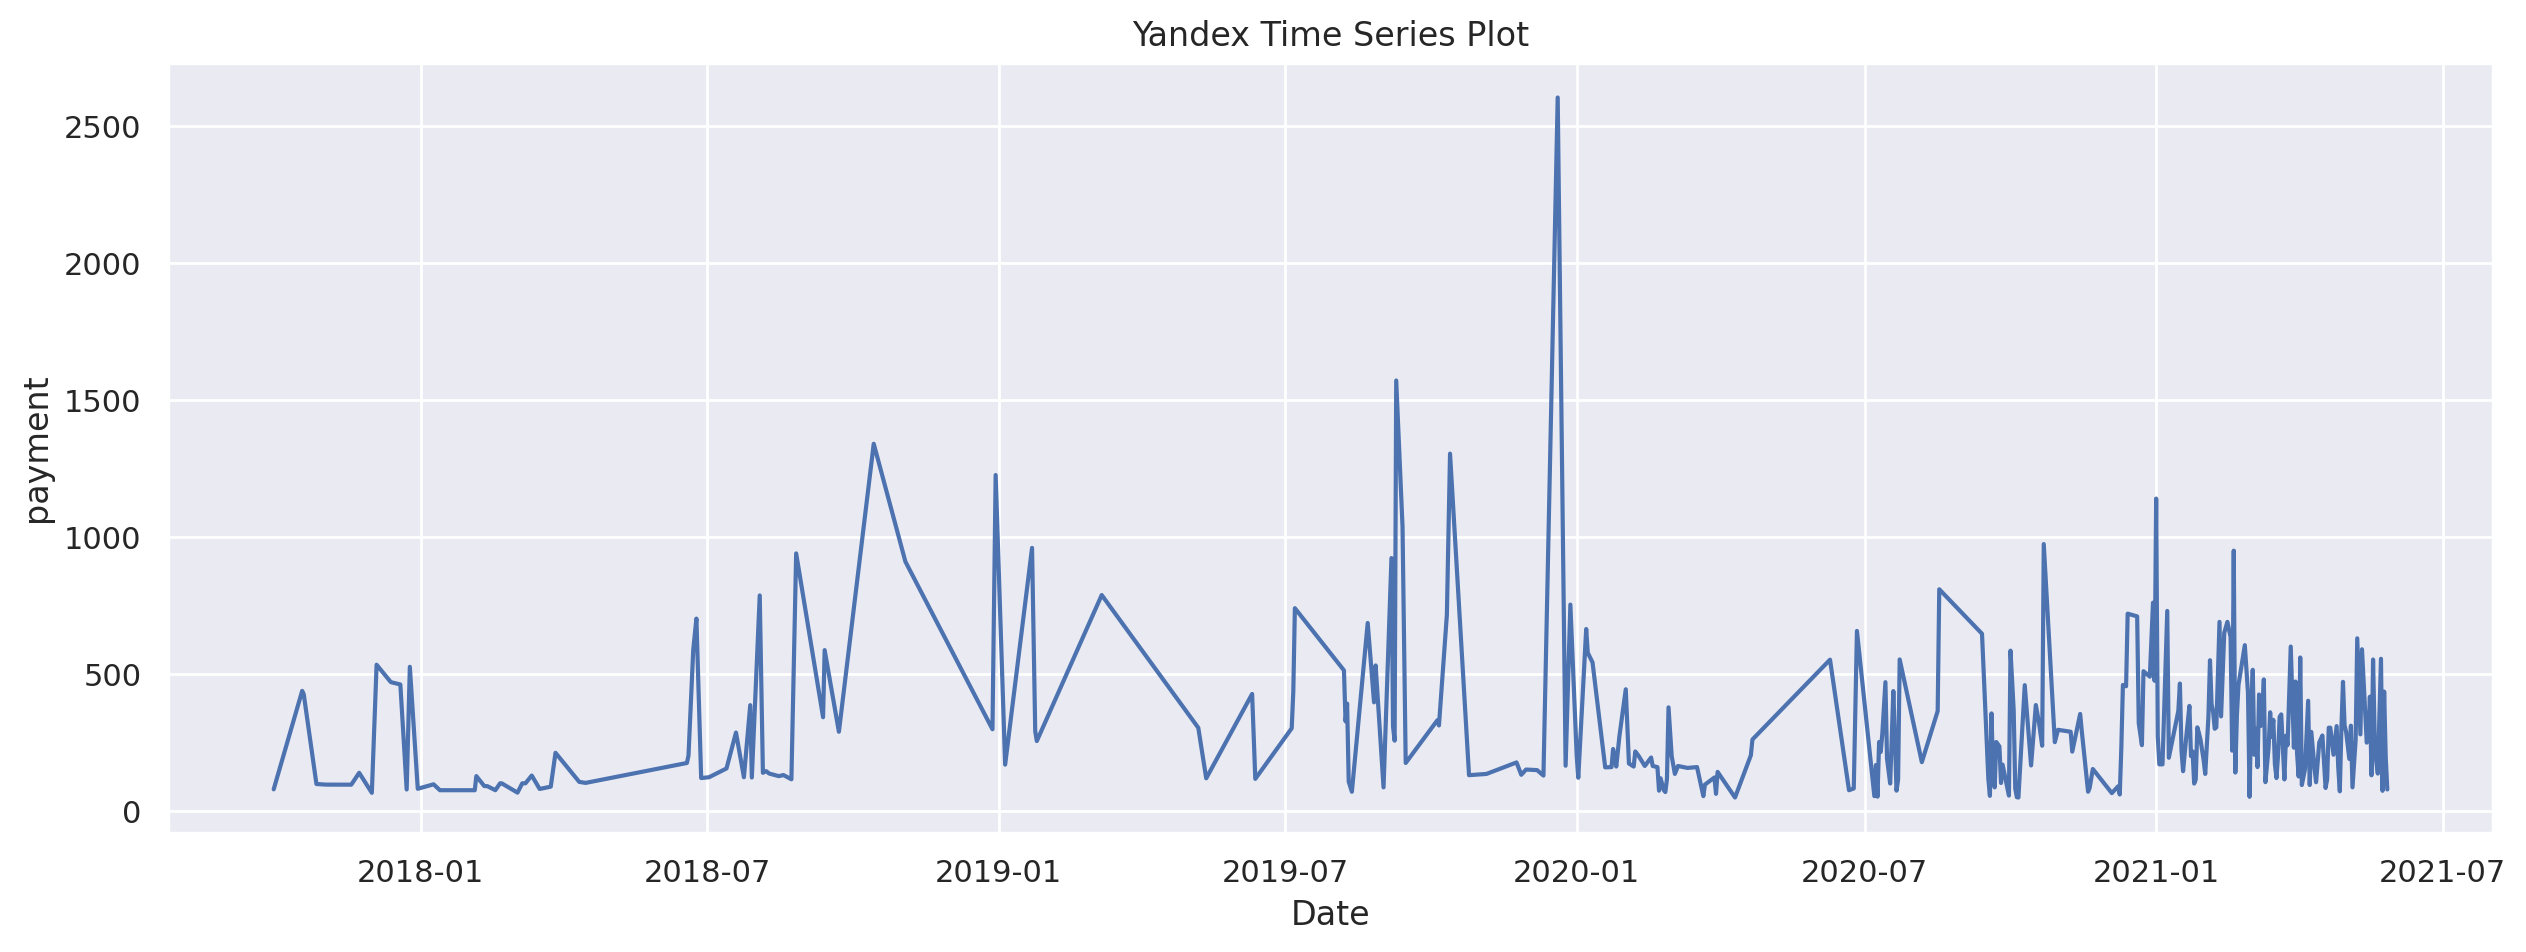

In [8]:
plt.figure(figsize=(10, 6))  # Set figure size

# Plot the time series
plt.figure(figsize=(15, 5))
plt.plot(df['payment_cost'], linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('payment')
plt.title('Yandex Time Series Plot')
# Show plot
plt.show()


In [9]:
#  import loggin and mute unimportant diagnostic messages:
import logging

logging.getLogger().setLevel(logging.ERROR)

# Prophet
from prophet import Prophet

In [10]:
# Required format for prophet
df = df.reset_index()
df.columns = ["ds", "y"]

In [11]:
df

,ds,y
0,2017-09-30,78.775000
1,2017-10-18,438.150000
2,2017-10-19,425.500000
3,2017-10-27,98.325000
4,2017-11-02,96.025000
...,...,...
310,2021-05-23,555.225000
311,2021-05-24,73.450000
312,2021-05-25,435.683333
313,2021-05-26,195.275000


In [12]:
# Splitting to have training set 
prediction_size = 74
train_df = df[:-prediction_size]
train_df.tail()

,ds,y
236,2021-02-17,635.0
237,2021-02-18,220.0
238,2021-02-19,950.0
239,2021-02-20,140.0
240,2021-02-21,350.0


In [13]:
model = Prophet()
model.fit(train_df);

19:21:33 - cmdstanpy - INFO - Chain [1] start processing
19:21:33 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
future = model.make_future_dataframe(periods=prediction_size)
future.tail()

,ds
310,2021-05-02
311,2021-05-03
312,2021-05-04
313,2021-05-05
314,2021-05-06


In [15]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
310,2021-05-02,321.613445,-83.588268,579.371435,321.206603,322.051108,-60.309664,-60.309664,-60.309664,25.438551,25.438551,25.438551,-85.748215,-85.748215,-85.748215,0.0,0.0,0.0,261.303781
311,2021-05-03,321.645550,-113.471069,587.739886,321.230863,322.096441,-80.977430,-80.977430,-80.977430,-0.848220,-0.848220,-0.848220,-80.129211,-80.129211,-80.129211,0.0,0.0,0.0,240.668120
312,2021-05-04,321.677656,-118.179072,550.148847,321.254698,322.125022,-108.117285,-108.117285,-108.117285,-33.653651,-33.653651,-33.653651,-74.463634,-74.463634,-74.463634,0.0,0.0,0.0,213.560371
313,2021-05-05,321.709761,-154.316875,472.266327,321.273886,322.168658,-153.806980,-153.806980,-153.806980,-84.952085,-84.952085,-84.952085,-68.854896,-68.854896,-68.854896,0.0,0.0,0.0,167.902781
314,2021-05-06,321.741867,-79.145440,584.494150,321.292659,322.217129,-69.108235,-69.108235,-69.108235,-5.696302,-5.696302,-5.696302,-63.411933,-63.411933,-63.411933,0.0,0.0,0.0,252.633632


**We see our original payments in scatter dots, predictions in blue line and colored blue regions are intervals. One may notice that model treats many points of the data as outliers (dots outside blue region)**

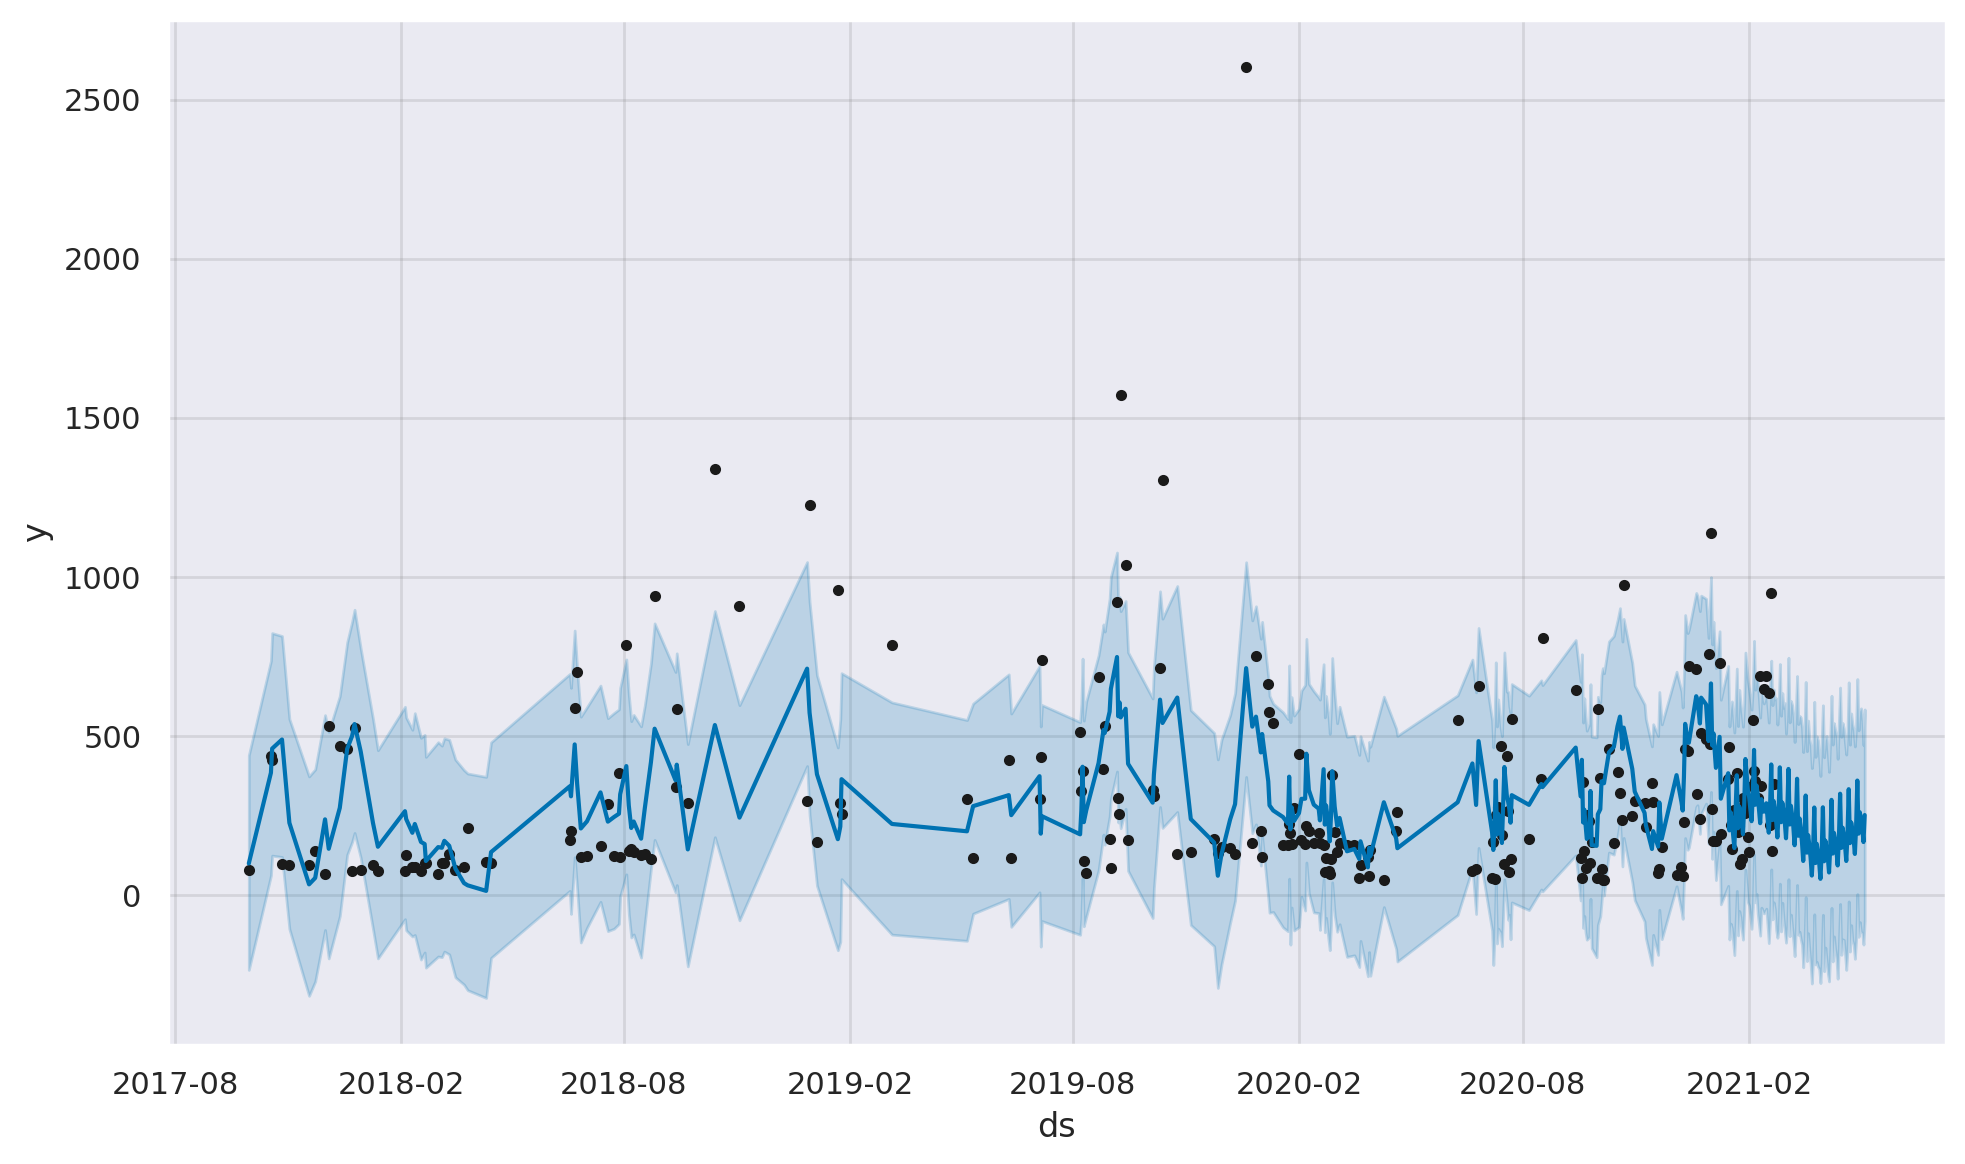

In [16]:
model.plot(forecast);

Below is component split on **trend**, **weekly** and **yearly** seasonality of our data

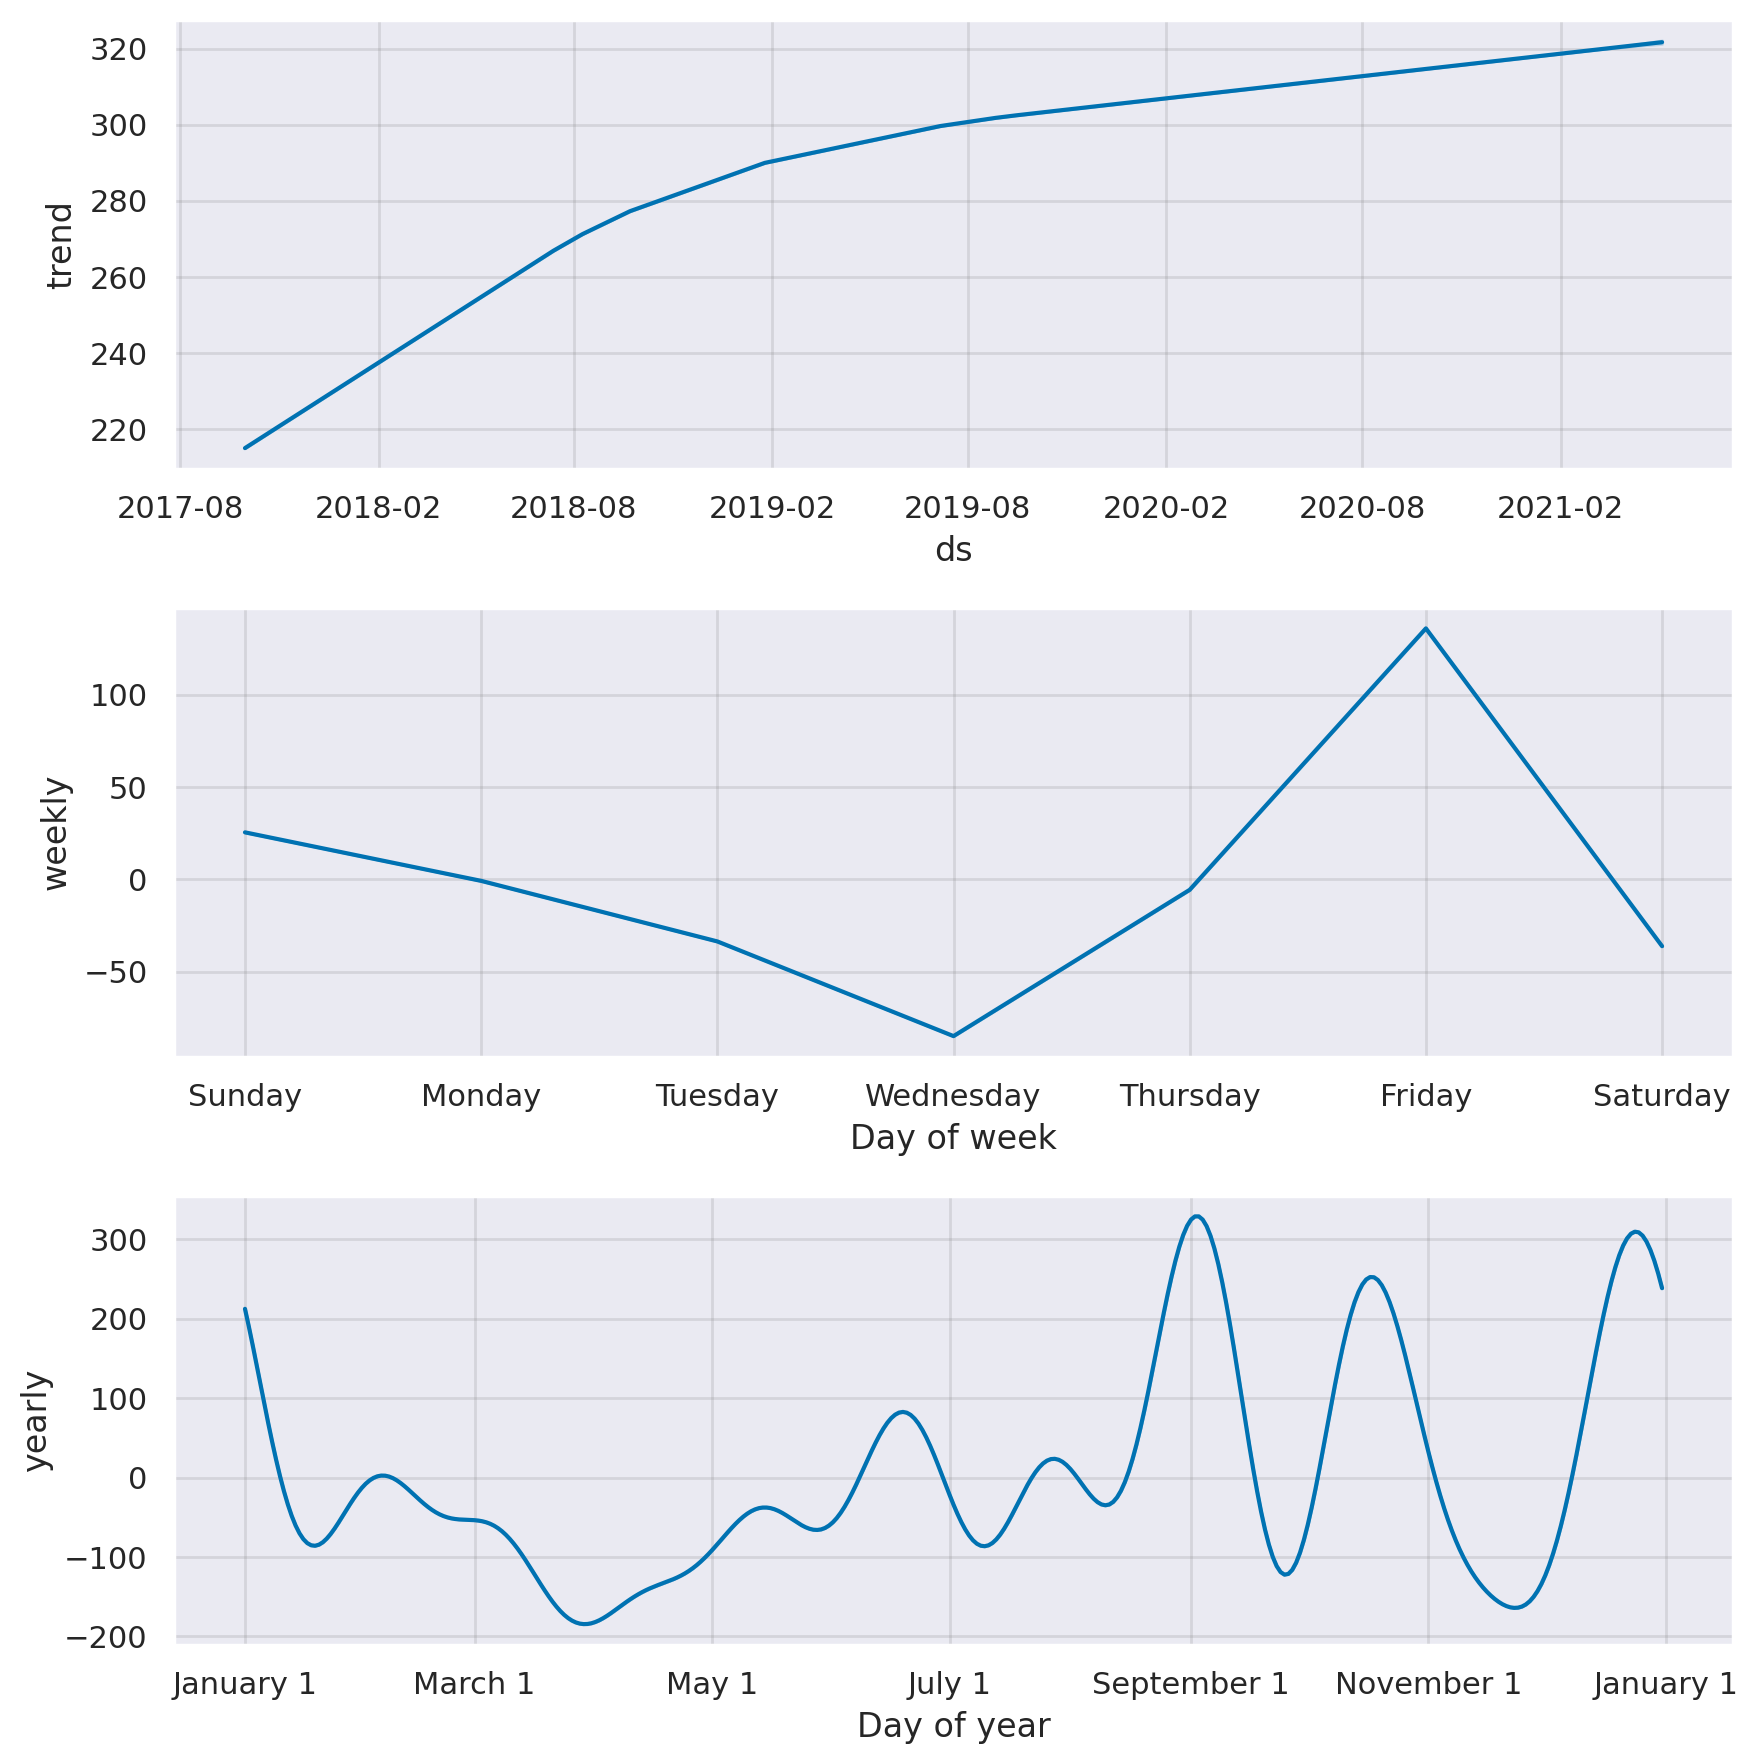

In [17]:
model.plot_components(forecast);

## Forecast quality evaluation

In [18]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.

       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
        historical.set_index("ds")
    )

In [19]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2021-05-02,261.303781,-83.588268,579.371435,NaN
2021-05-03,240.668120,-113.471069,587.739886,190.000000
2021-05-04,213.560371,-118.179072,550.148847,311.133333
2021-05-05,167.902781,-154.316875,472.266327,86.116667
2021-05-06,252.633632,-79.145440,584.494150,NaN


$MAPE = \frac{1}{n} \sum_{t=1}^{n} \left| \frac{A_t - F_t}{A_t} \right| \times 100$

$MAE = \frac{1}{n} \sum_{i=1}^{n} \left| A_i - F_i \right|$


$A_t$  is the actual value at time 

$F_t$  is the forecasted/predicted value at time 

$n$ is the total number of observations.

In [20]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.

       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """

    # Make a copy
    df = df.copy()

    # Formulas for MAE and MAPE
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] / df["y"]

    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model.

    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]

    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {"MAPE": error_mean("p"), "MAE": error_mean("e")}

In [21]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 54.45853915926386
MAE 131.7330380401877


<Figure size 1000x600 with 0 Axes>

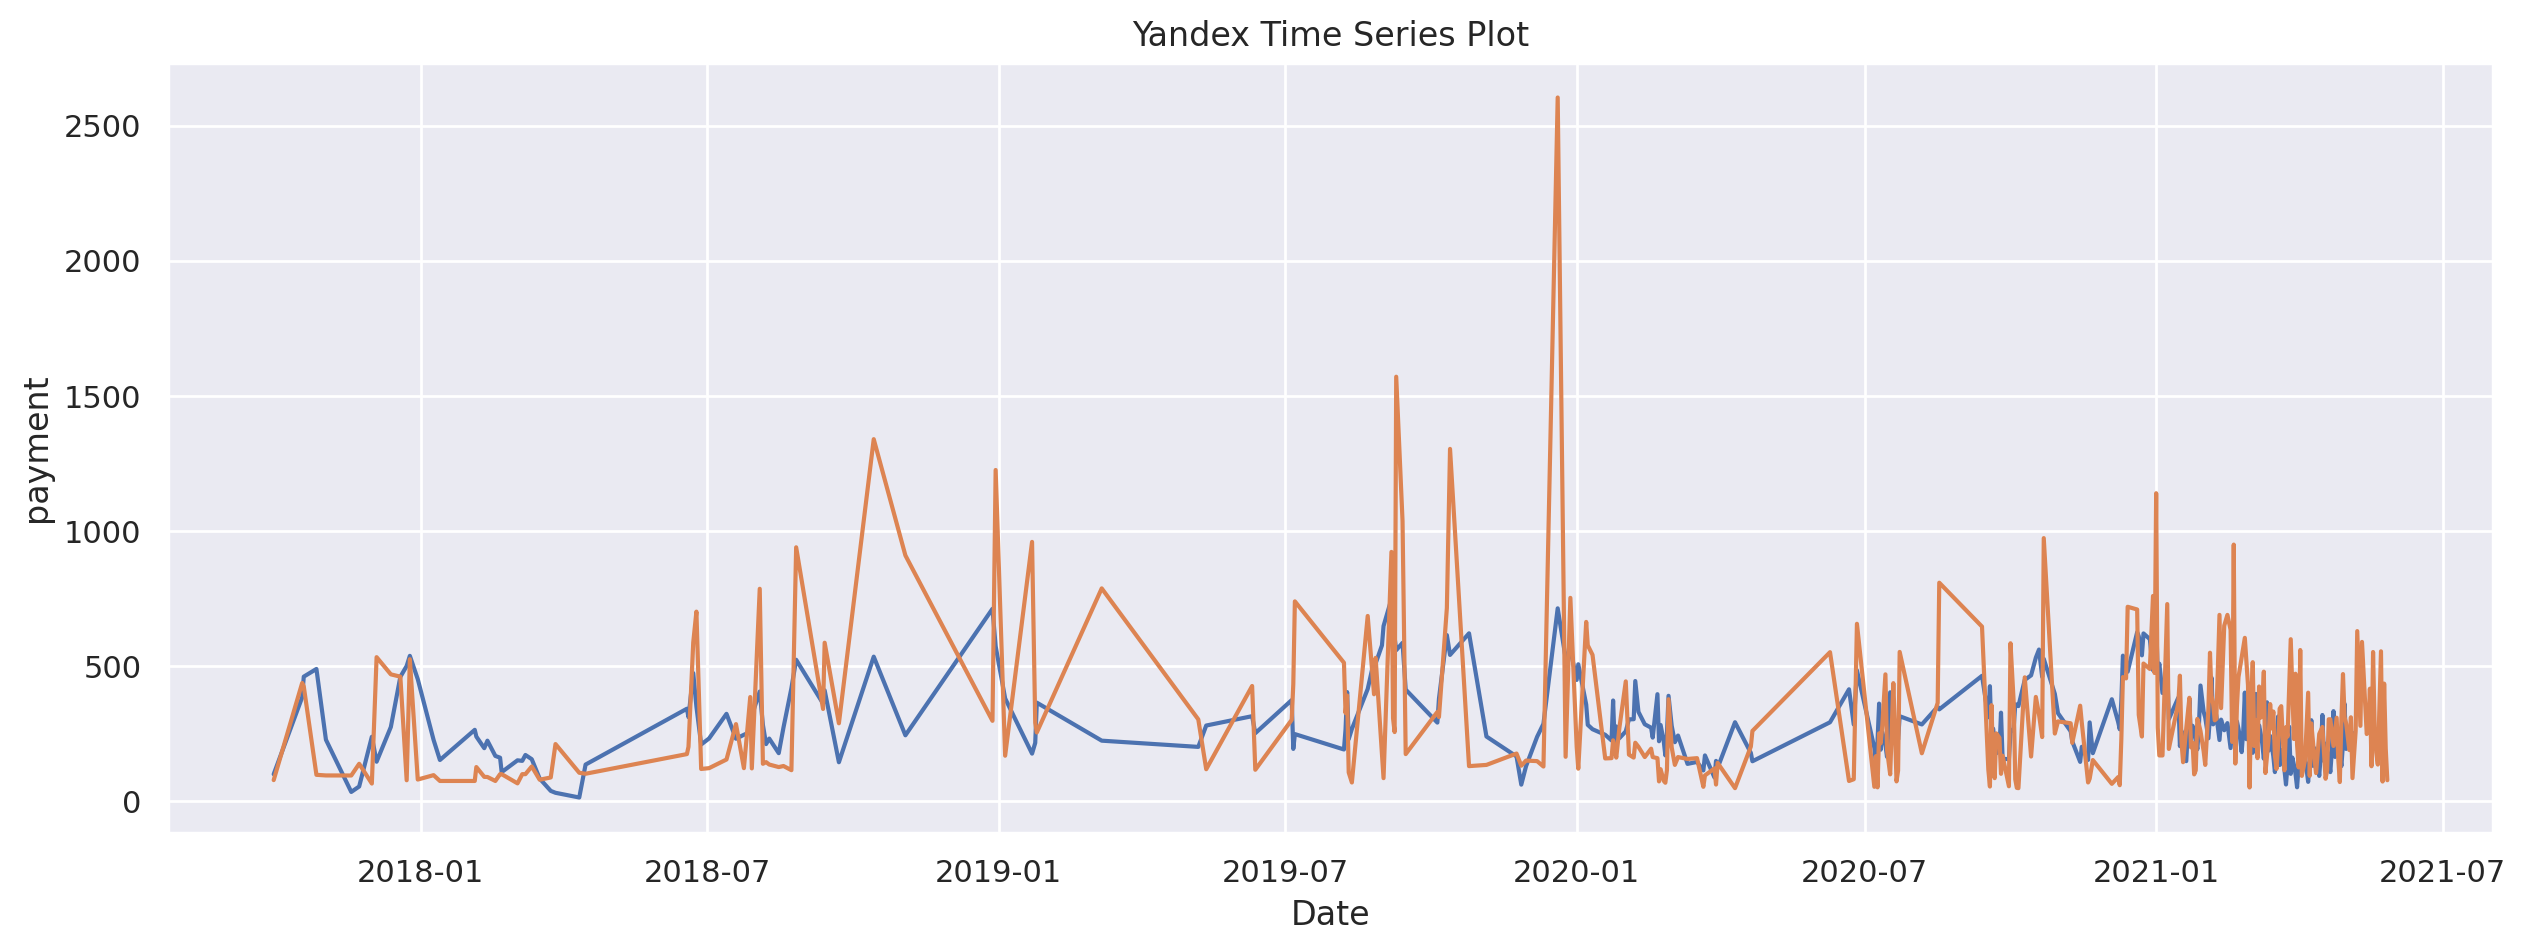

In [44]:
plt.figure(figsize=(10, 6))  # Set figure size

# Plot the time series
plt.figure(figsize=(15, 5))
plt.plot(forecast['ds'],forecast['yhat'], linestyle='-')
plt.plot(df['ds'],df['y'], linestyle='-')
# Add labels and title
plt.xlabel('Date')
plt.ylabel('payment')
plt.title('Yandex Time Series Plot')
# Show plot
plt.show()
